In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in the csv
df = pd.read_csv("../data/raw/beer_reviews.csv")

df_cleaned = df.copy()

# Select necessary columns
df_cleaned = df_cleaned[['review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'beer_abv','brewery_name','beer_name', 'beer_style']]


In [3]:
# Handle missing values
df_cleaned['beer_abv'].fillna(df_cleaned['beer_abv'].mean(), inplace=True)
df_cleaned['beer_name'].fillna('unknown', inplace=True)
df_cleaned['brewery_name'].fillna('unknown', inplace=True)


In [4]:
# Encode the beer_style column
le = LabelEncoder()
df_cleaned['beer_style'] = le.fit_transform(df_cleaned['beer_style'])

# Select columns to be encoded
cols_to_encode = ['beer_name', 'brewery_name']

# Instantiate encoder
encoder = ce.TargetEncoder(cols=cols_to_encode)

In [5]:
# Fit and transform the columns
df_encoded = encoder.fit_transform(df_cleaned[cols_to_encode], df_cleaned['beer_style'])
# Replace original columns with encoded ones in the dataframe
df_cleaned.drop(cols_to_encode, axis=1, inplace=True)
df_cleaned = pd.concat([df_cleaned, df_encoded], axis=1)

y = df_cleaned.pop("beer_style")
X = df_cleaned

In [6]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


In [8]:
# Convert DataFrames to PyTorch Tensors
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).long()
X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).long()

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 100)
        self.top_layer = nn.Linear(100, 104)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.top_layer(x)
        return x

In [10]:
# Instantiate the model
model = NeuralNet(X_train.shape[1])

In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Train the model
num_epochs = 60
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=256, shuffle=True)
history = {'train_loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        
    # Record losses
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}')


Epoch 1/60, Train Loss: 1.5843690633773804, Validation Loss: 1.4736655950546265
Epoch 2/60, Train Loss: 1.161666989326477, Validation Loss: 1.2593199014663696
Epoch 3/60, Train Loss: 1.0387156009674072, Validation Loss: 1.1495341062545776
Epoch 4/60, Train Loss: 0.7609646916389465, Validation Loss: 1.100918173789978
Epoch 5/60, Train Loss: 1.0953822135925293, Validation Loss: 1.0582107305526733
Epoch 6/60, Train Loss: 1.1504658460617065, Validation Loss: 1.0195863246917725
Epoch 7/60, Train Loss: 1.2605818510055542, Validation Loss: 0.9905299544334412
Epoch 8/60, Train Loss: 0.7446319460868835, Validation Loss: 0.9804506897926331
Epoch 9/60, Train Loss: 0.9489849209785461, Validation Loss: 0.9519550204277039
Epoch 10/60, Train Loss: 1.037377119064331, Validation Loss: 0.9365594387054443
Epoch 11/60, Train Loss: 0.9146556258201599, Validation Loss: 0.9291761517524719
Epoch 12/60, Train Loss: 0.8066667318344116, Validation Loss: 0.9164726138114929
Epoch 13/60, Train Loss: 0.5428170561790

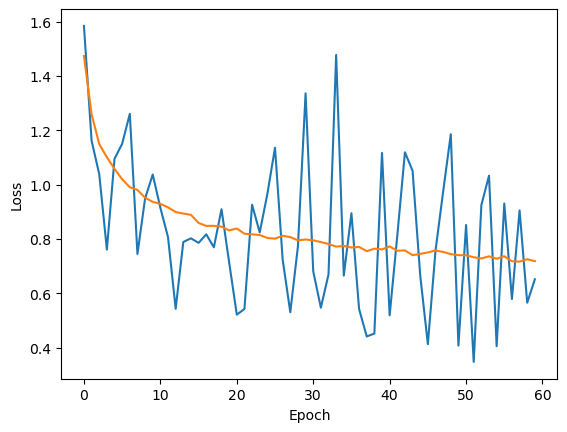

In [13]:
plt.plot(history['train_loss'], label='Loss training')
plt.plot(history['val_loss'], label='Loss validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
# Save the model
torch.save(model.state_dict(), "../models/best.pth")